In [1]:
!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from math import floor,ceil,sqrt
import sys
import warnings
import datetime as dt

if not sys.warnoptions:
    warnings.simplefilter("ignore")
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.2 MB/s eta 0:00:00


In [2]:
uber = pd.read_csv('/kaggle/input/historical-stock-price-of-10-popular-companies/Uber.csv')
amazon = pd.read_csv('/kaggle/input/historical-stock-price-of-10-popular-companies/Amazon.csv')
apple = pd.read_csv('/kaggle/input/historical-stock-price-of-10-popular-companies/Apple.csv')
facebook = pd.read_csv('/kaggle/input/historical-stock-price-of-10-popular-companies/Facebook.csv')
netflix = pd.read_csv('/kaggle/input/historical-stock-price-of-10-popular-companies/Netflix.csv')
google = pd.read_csv('/kaggle/input/historical-stock-price-of-10-popular-companies/Google.csv')

uber.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500
1,2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400
2,2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100
3,2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100
4,2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500


In [3]:
uber.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [4]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       666 non-null    object 
 1   Open       666 non-null    float64
 2   High       666 non-null    float64
 3   Low        666 non-null    float64
 4   Close      666 non-null    float64
 5   Adj Close  666 non-null    float64
 6   Volume     666 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 36.5+ KB


Text(0.5, 1.0, 'Stock Price of Uber over the Years')

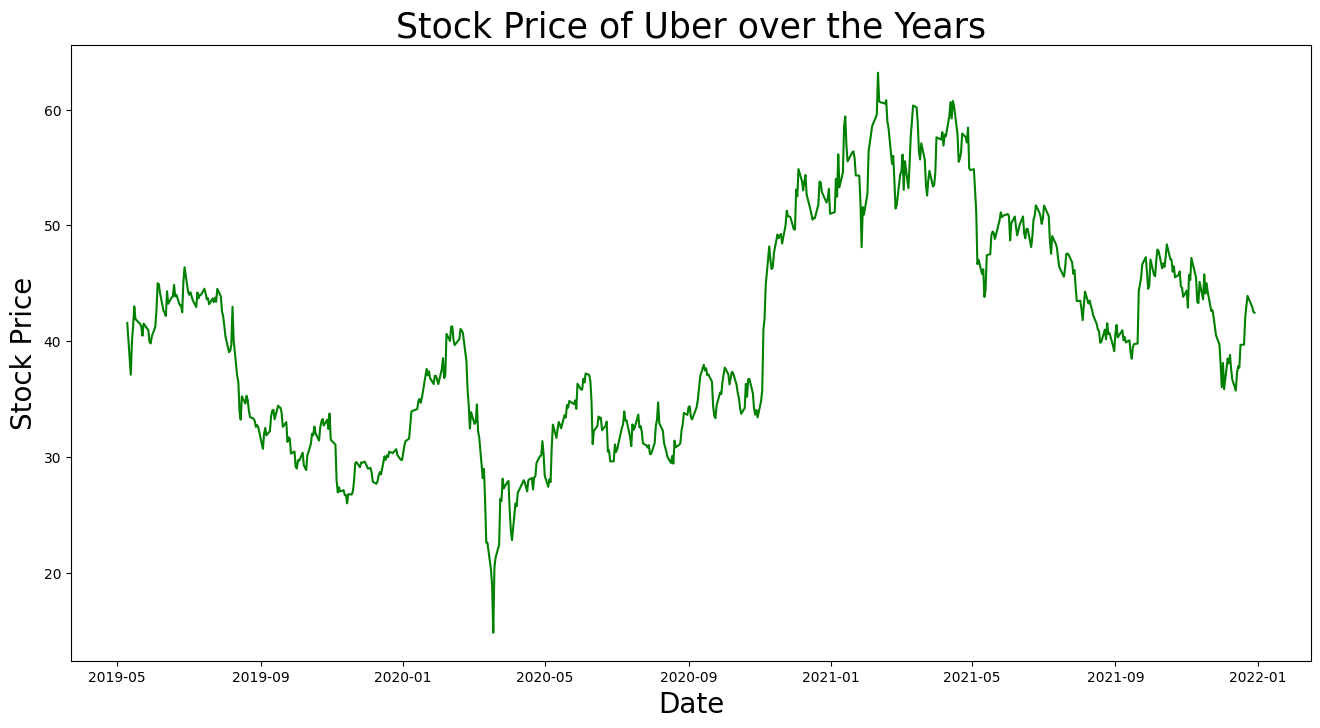

In [5]:
uber['Date'] = pd.to_datetime(uber['Date'], format='%Y-%m-%d')
uber['Date'] = uber['Date'].dt.strftime('%d-%m-%Y') 
uber['Date'] = pd.to_datetime(uber['Date'], format='%d-%m-%Y')
uber.index = uber['Date']
plt.figure(figsize=(16,8))
plt.plot(uber['Close'], label='Close Price history',color='g')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Uber over the Years',size=25)

In [6]:
def lstm_prediction(data):
    shape=data.shape[0]
    data_new=data[['Close']]
    data_new.head()
    dataset = data_new.values
    train=data_new[:ceil(shape*0.75)]
    valid=data_new[ceil(shape*0.75):]
    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    inputs = data_new[len(data_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid['Predictions'] = closing_price
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (500, 1)
Shape of Validation Set (166, 1)
460/460 - 8s - 18ms/step - loss: 0.0094
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
RMSE value on validation set: 2.4202856632557137
-----------------------------------------------------------
-----------------------------------------------------------


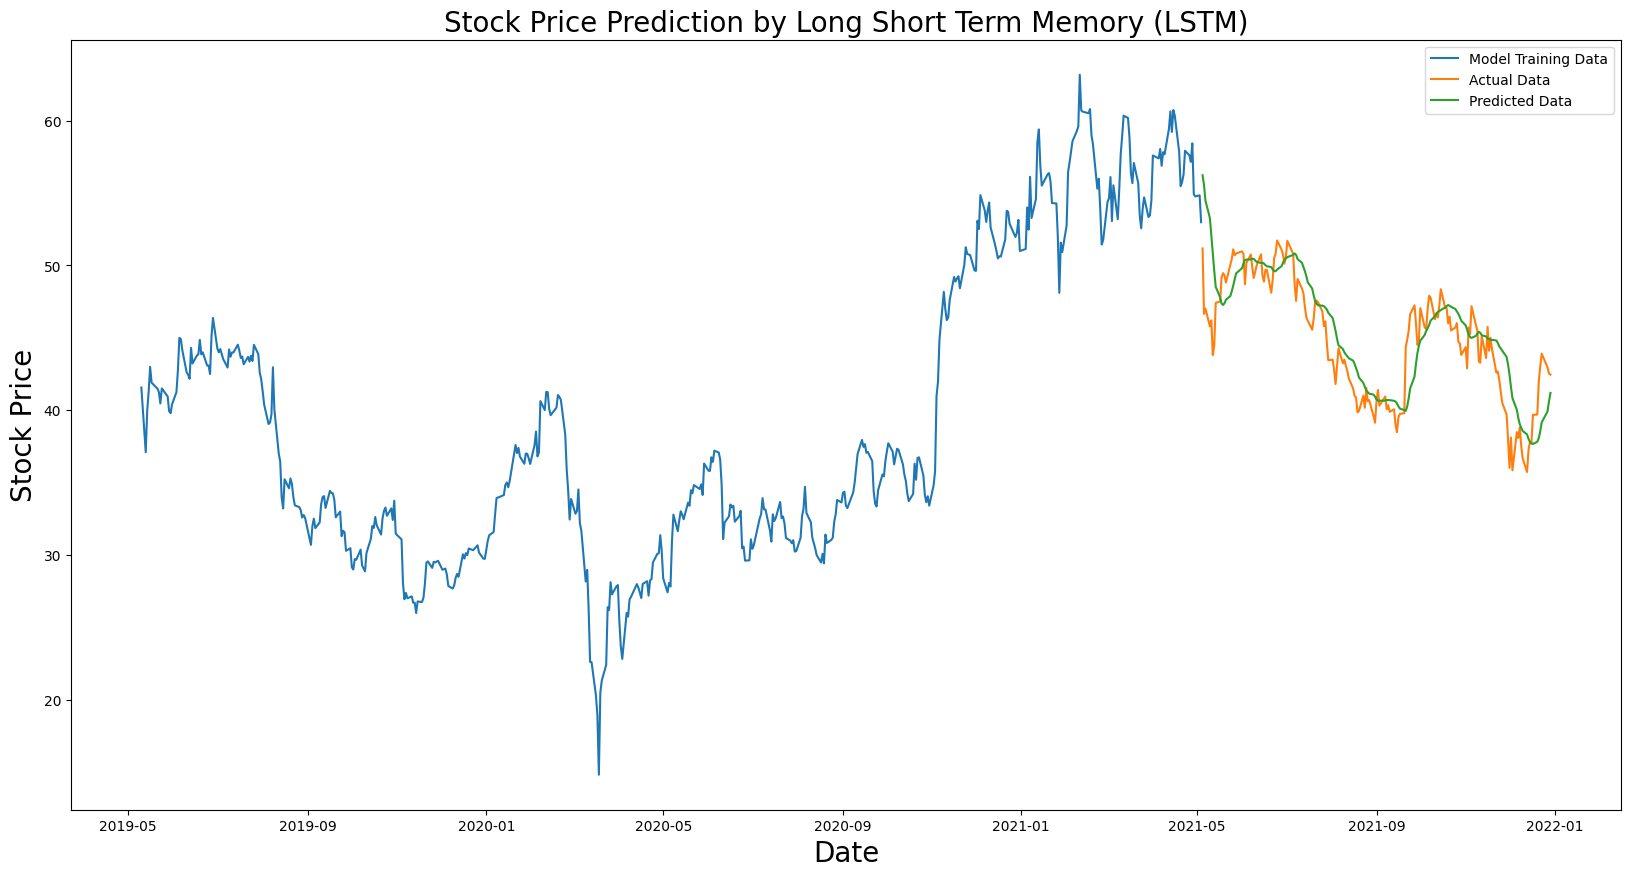

In [7]:
lstm_prediction(uber)

In [8]:
amazon['company'] = 'amazon'
apple['company'] = 'apple'
facebook['company'] = 'facebook'
google['company'] = 'google'
netflix['company'] = 'netflix'

data = pd.concat([amazon,apple,facebook,google,netflix])

In [9]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company
0,2015-01-02,312.579987,314.750000,306.959991,308.519989,308.519989,2783200,amazon
1,2015-01-05,307.010010,308.380005,300.850006,302.190002,302.190002,2774200,amazon
2,2015-01-06,302.239990,303.000000,292.380005,295.290009,295.290009,3519000,amazon
3,2015-01-07,297.500000,301.279999,295.329987,298.420013,298.420013,2640300,amazon
4,2015-01-08,300.320007,303.140015,296.109985,300.459991,300.459991,3088400,amazon


In [10]:
data.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
company      False
dtype: bool

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8805 entries, 0 to 1760
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8805 non-null   object 
 1   Open       8805 non-null   float64
 2   High       8805 non-null   float64
 3   Low        8805 non-null   float64
 4   Close      8805 non-null   float64
 5   Adj Close  8805 non-null   float64
 6   Volume     8805 non-null   int64  
 7   company    8805 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 619.1+ KB


In [12]:
# Group by company and calculate descriptive statistics
desc = data.groupby('company').describe().T
desc = desc.loc[~desc.index.get_level_values(0).str.contains('Date')]
desc

company                amazon         apple      facebook        google  \
Open      count  1.761000e+03  1.761000e+03  1.761000e+03  1.761000e+03   
          mean   1.656975e+03  6.121540e+01  1.814095e+02  1.220631e+03   
          std    1.007431e+03  4.013286e+01  7.510952e+01  6.108901e+02   
          min    2.862800e+02  2.250000e+01  7.404000e+01  4.932957e+02   
          25%    7.666000e+02  3.151000e+01  1.231000e+02  7.742500e+02   
          50%    1.604000e+03  4.386000e+01  1.717900e+02  1.082470e+03   
          75%    2.125020e+03  7.681000e+01  2.101900e+02  1.390800e+03   
          max    3.744000e+03  1.811200e+02  3.816800e+02  3.020000e+03   
High      count  1.761000e+03  1.761000e+03  1.761000e+03  1.761000e+03   
          mean   1.674001e+03  6.186973e+01  1.834925e+02  1.232290e+03   
          std    1.018769e+03  4.062463e+01  7.610609e+01  6.165934e+02   
          min    2.907900e+02  2.291750e+01  7.483000e+01  4.946180e+02   
          25%    7.712200e+02  3.173500e+01  1.242600e+02  7.795300e+02   
          50%    1.623560e+03  4.432500e+01  1.732400e+02  1.094170e+03   
          75%    2.159040e+03  7.794250e+01  2.116200e+02  1.411580e+03   
          max    3.773080e+03  1.821300e+02  3.843300e+02  3.037000e+03   
Low       count  1.761000e+03  1.761000e+03  1.761000e+03  1.761000e+03   
          mean   1.637994e+03  6.058725e+01  1.793131e+02  1.209582e+03   
          std    9.949439e+02  3.965906e+01  7.418334e+01  6.058046e+02   
          min    2.852500e+02  2.236750e+01  7.200000e+01  4.862251e+02   
          25%    7.612000e+02  3.124250e+01  1.223100e+02  7.687950e+02   
          50%    1.590870e+03  4.362500e+01  1.695600e+02  1.070000e+03   
          75%    2.088000e+03  7.607250e+01  2.087100e+02  1.377152e+03   
          max    3.696790e+03  1.785300e+02  3.788100e+02  2.997750e+03   
Close     count  1.761000e+03  1.761000e+03  1.761000e+03  1.761000e+03   
          mean   1.656407e+03  6.126022e+01  1.814769e+02  1.221455e+03   
          std    1.006562e+03  4.017198e+01  7.514346e+01  6.115310e+02   
          min    2.869500e+02  2.258500e+01  7.405000e+01  4.912014e+02   
          25%    7.673300e+02  3.147500e+01  1.234100e+02  7.728800e+02   
          50%    1.603070e+03  4.396250e+01  1.714700e+02  1.082480e+03   
          75%    2.134870e+03  7.737750e+01  2.108500e+02  1.393340e+03   
          max    3.731410e+03  1.803300e+02  3.821800e+02  3.014180e+03   
Adj Close count  1.761000e+03  1.761000e+03  1.761000e+03  1.761000e+03   
          mean   1.656407e+03  5.979038e+01  1.814769e+02  1.221455e+03   
          std    1.006562e+03  4.075529e+01  7.514346e+01  6.115310e+02   
          min    2.869500e+02  2.103630e+01  7.405000e+01  4.912014e+02   
          25%    7.673300e+02  2.869498e+01  1.234100e+02  7.728800e+02   
          50%    1.603070e+03  4.240198e+01  1.714700e+02  1.082480e+03   
          75%    2.134870e+03  7.624496e+01  2.108500e+02  1.393340e+03   
          max    3.731410e+03  1.803300e+02  3.821800e+02  3.014180e+03   
Volume    count  1.761000e+03  1.761000e+03  1.761000e+03  1.761000e+03   
          mean   4.184049e+06  1.381024e+08  2.206907e+07  1.671220e+06   
          std    2.129974e+06  6.977506e+07  1.292301e+07  8.150576e+05   
          min    8.813000e+05  4.100000e+07  5.913100e+06  3.468000e+05   
          25%    2.792400e+06  9.075730e+07  1.437970e+07  1.191400e+06   
          50%    3.614500e+06  1.189944e+08  1.887410e+07  1.466700e+06   
          75%    4.922200e+06  1.654288e+08  2.521830e+07  1.907200e+06   
          max    2.385610e+07  6.488252e+08  1.698037e+08  1.116490e+07   

company               netflix  
Open      count  1.761000e+03  
          mean   2.872211e+02  
          std    1.694081e+02  
          min    4.602143e+01  
          25%    1.201000e+02  
          50%    2.919400e+02  
          75%    4.046900e+02  
          max    6.923500e+02  
High      count  1.761000e+03  
    

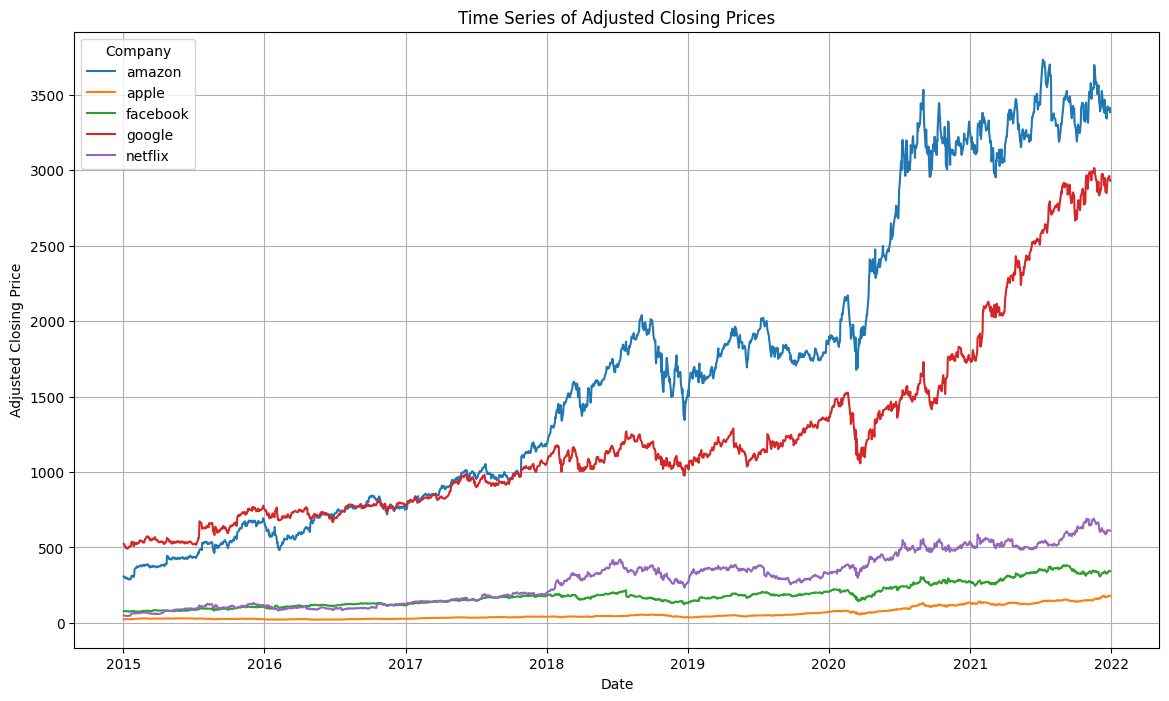

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

data['Date'] = pd.to_datetime(data['Date'])
plt.figure(figsize=(14, 8))
sns.lineplot(data=data, x='Date', y='Adj Close', hue='company')
plt.title('Time Series of Adjusted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.legend(title='Company')
plt.grid(True)
plt.show()

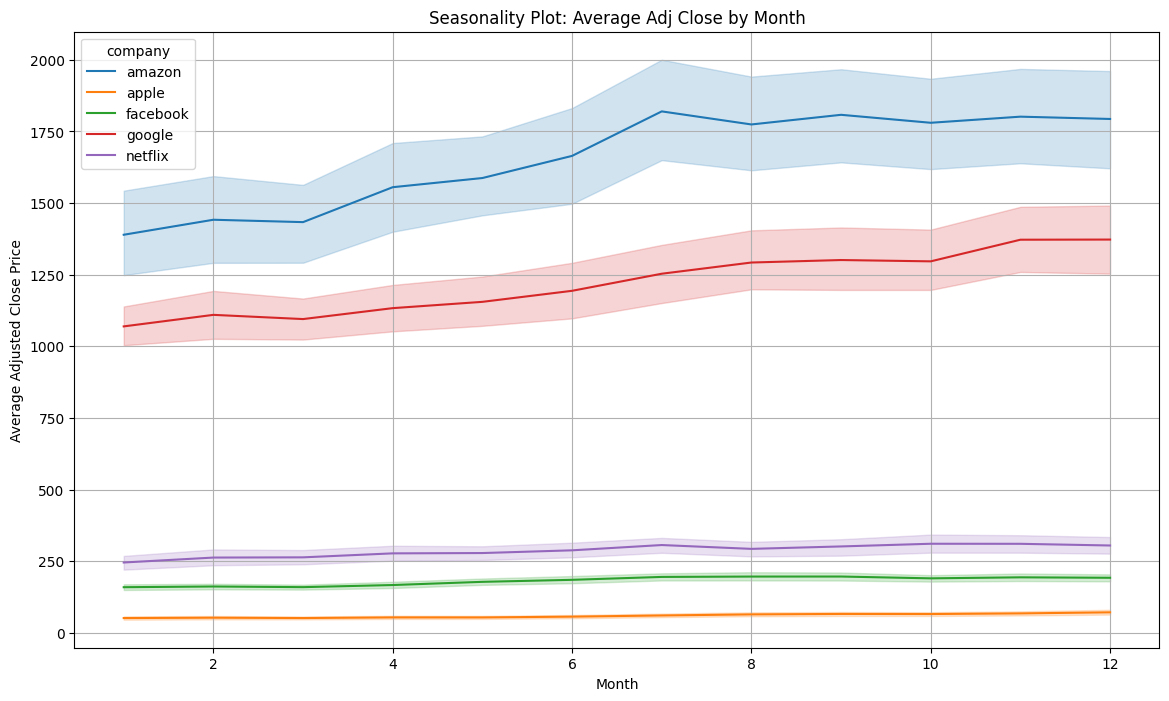

In [14]:
# Add month and year columns
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
# General seasonality plot: Average by month across all years
plt.figure(figsize=(14, 8))
sns.lineplot(data=data, x='Month', y='Adj Close', hue='company', estimator='mean')
plt.title('Seasonality Plot: Average Adj Close by Month')
plt.xlabel('Month')
plt.ylabel('Average Adjusted Close Price')
plt.grid(True)
plt.show()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8805 entries, 0 to 1760
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       8805 non-null   datetime64[ns]
 1   Open       8805 non-null   float64       
 2   High       8805 non-null   float64       
 3   Low        8805 non-null   float64       
 4   Close      8805 non-null   float64       
 5   Adj Close  8805 non-null   float64       
 6   Volume     8805 non-null   int64         
 7   company    8805 non-null   object        
 8   Month      8805 non-null   int32         
 9   Year       8805 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(2), int64(1), object(1)
memory usage: 687.9+ KB


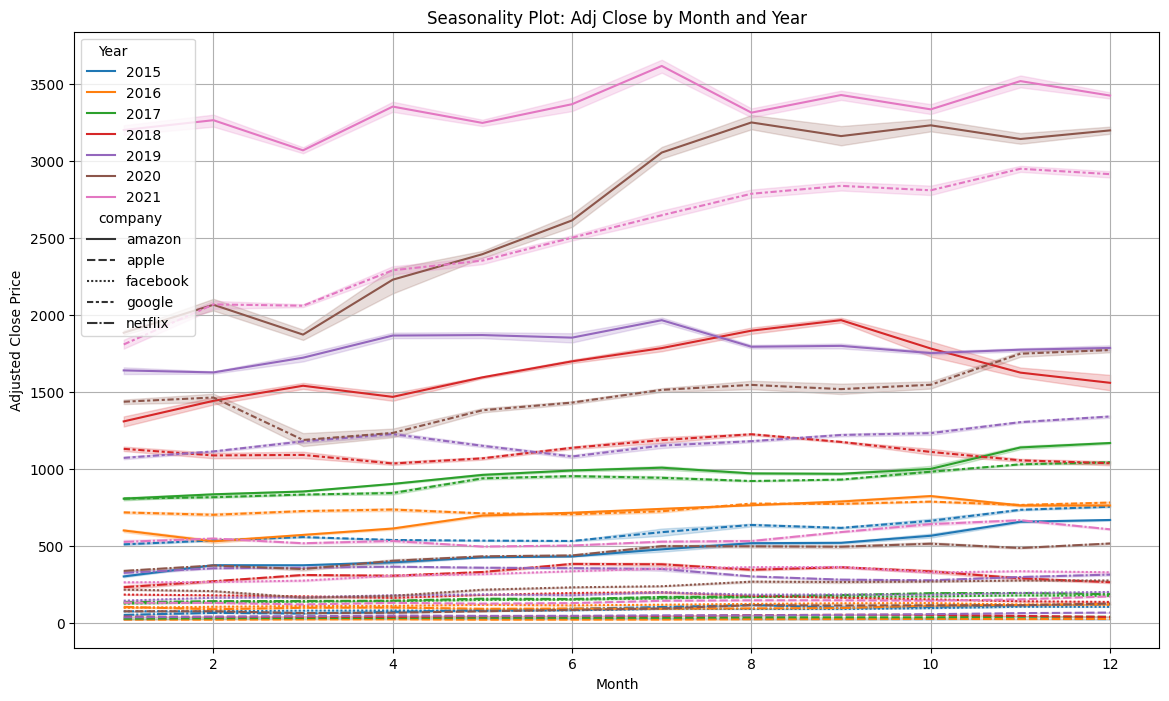

In [16]:
# Year-based seasonality plot: Average by month for each year
plt.figure(figsize=(14, 8))
sns.lineplot(data=data, x='Month', y='Adj Close', hue='Year', style='company', palette='tab10')
plt.title('Seasonality Plot: Adj Close by Month and Year')
plt.xlabel('Month')
plt.ylabel('Adjusted Close Price')
plt.grid(True)
plt.show()


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8805 entries, 0 to 1760
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       8805 non-null   datetime64[ns]
 1   Open       8805 non-null   float64       
 2   High       8805 non-null   float64       
 3   Low        8805 non-null   float64       
 4   Close      8805 non-null   float64       
 5   Adj Close  8805 non-null   float64       
 6   Volume     8805 non-null   int64         
 7   company    8805 non-null   object        
 8   Month      8805 non-null   int32         
 9   Year       8805 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(2), int64(1), object(1)
memory usage: 687.9+ KB


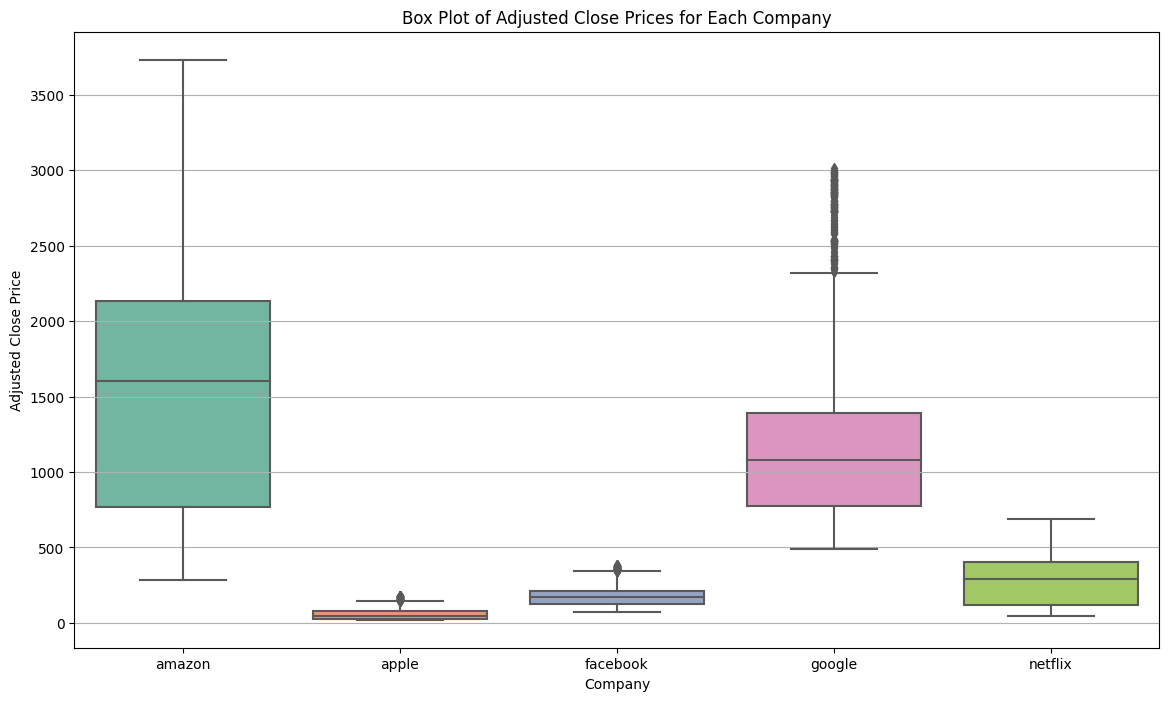

In [18]:
# Box plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='company', y='Adj Close', palette='Set2')
plt.title('Box Plot of Adjusted Close Prices for Each Company')
plt.xlabel('Company')
plt.ylabel('Adjusted Close Price')
plt.grid(axis='y')
plt.show()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8805 entries, 0 to 1760
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       8805 non-null   datetime64[ns]
 1   Open       8805 non-null   float64       
 2   High       8805 non-null   float64       
 3   Low        8805 non-null   float64       
 4   Close      8805 non-null   float64       
 5   Adj Close  8805 non-null   float64       
 6   Volume     8805 non-null   int64         
 7   company    8805 non-null   object        
 8   Month      8805 non-null   int32         
 9   Year       8805 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(2), int64(1), object(1)
memory usage: 687.9+ KB


<Figure size 1400x1000 with 0 Axes>

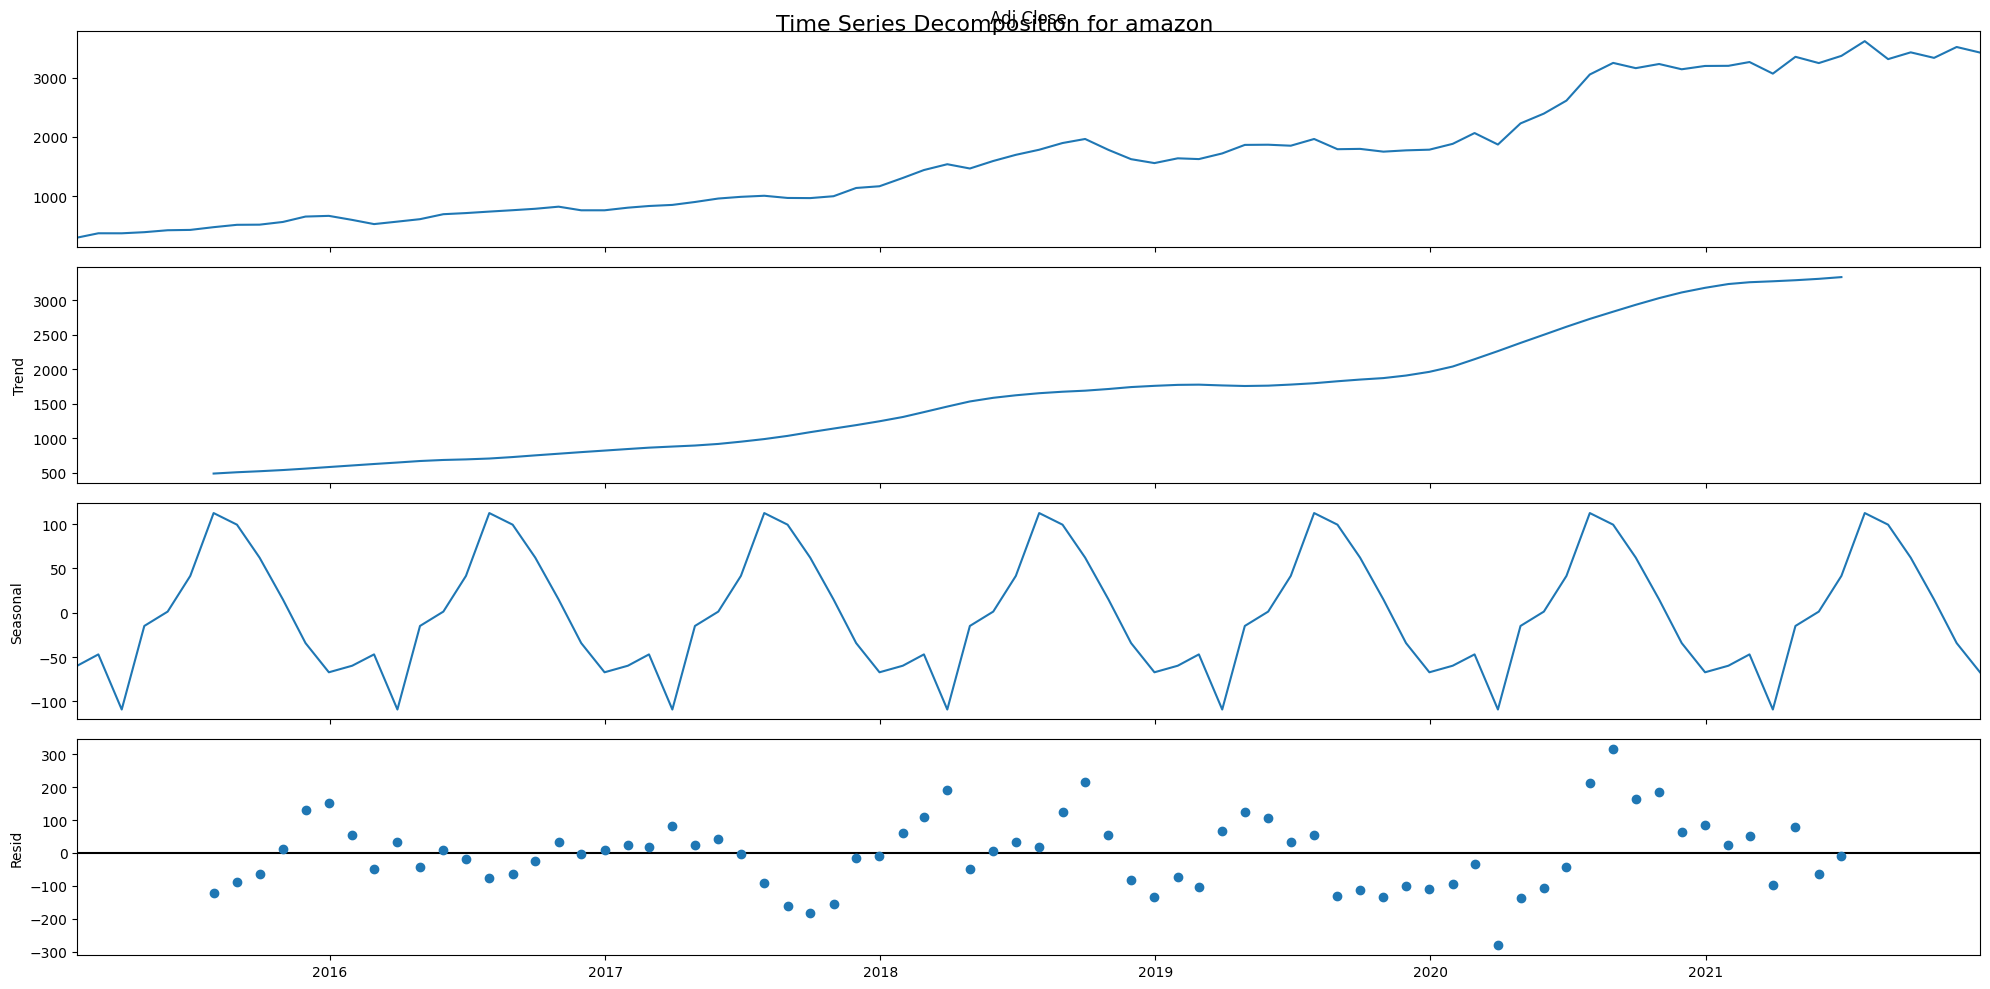

<Figure size 1400x1000 with 0 Axes>

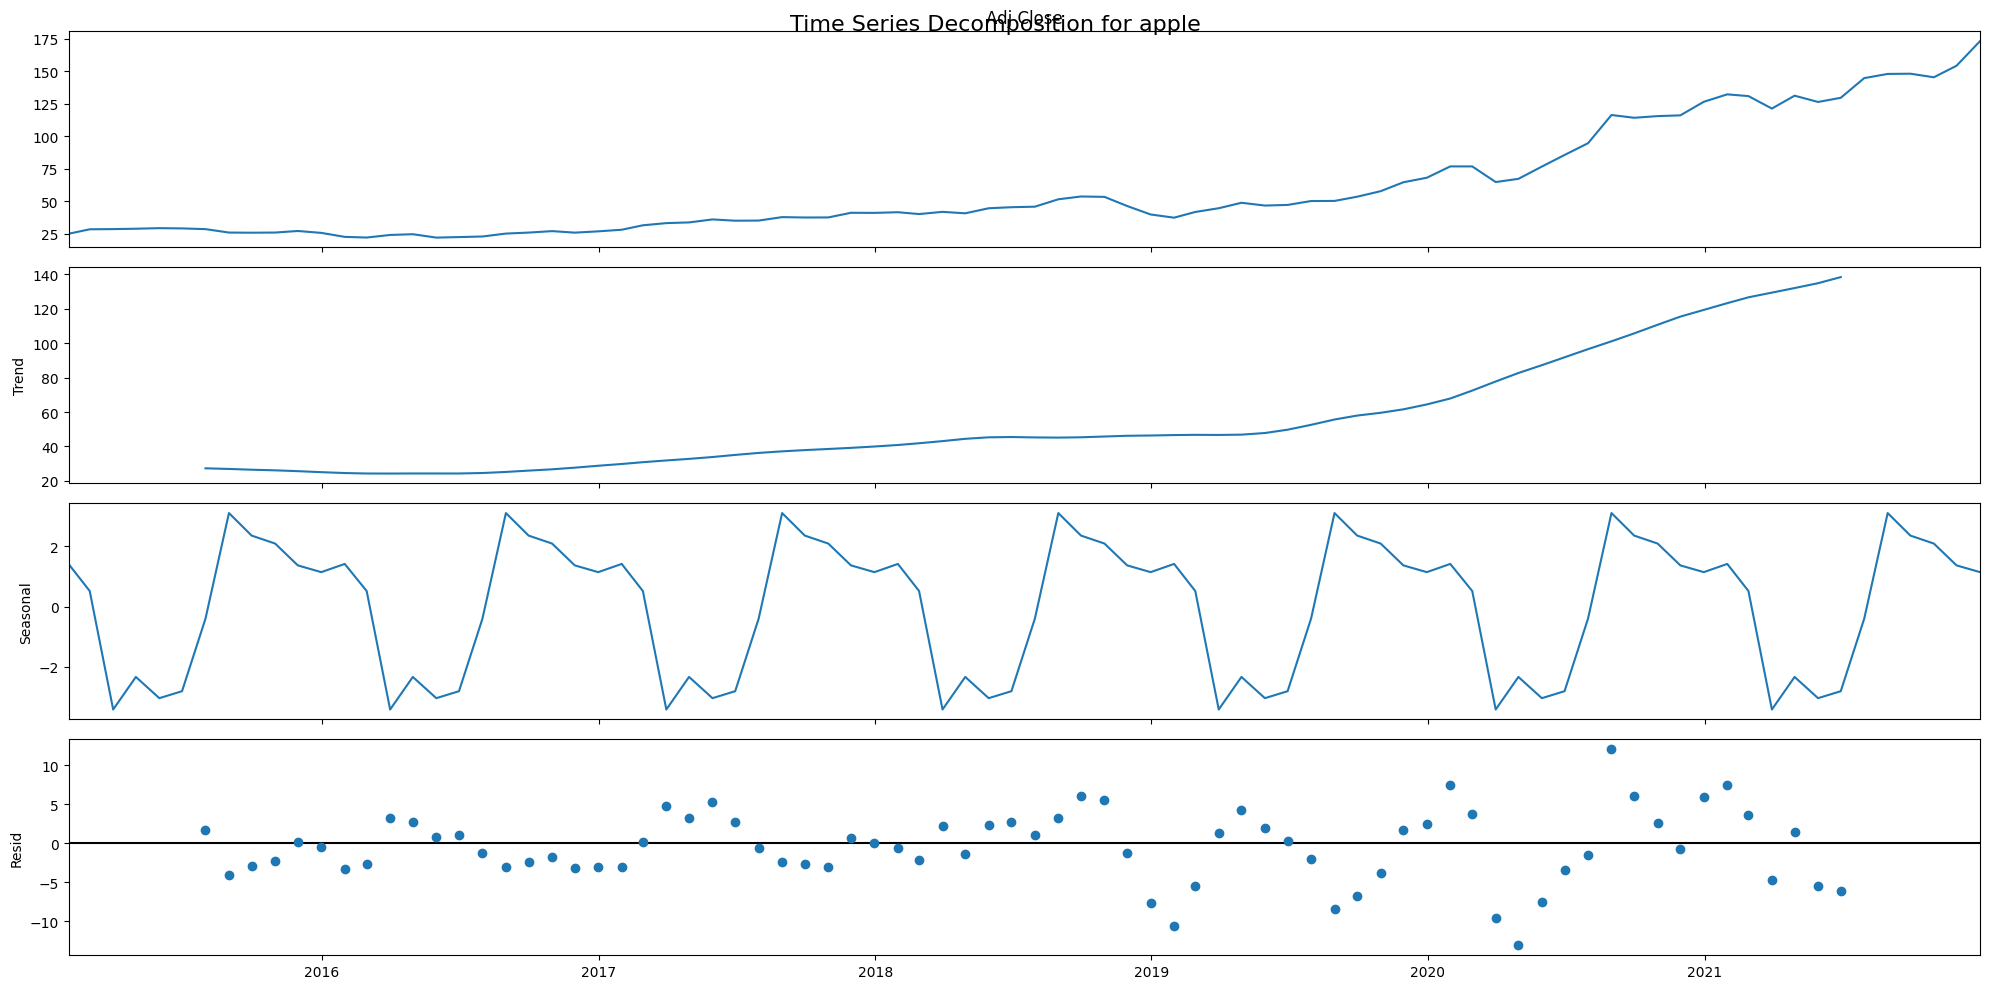

<Figure size 1400x1000 with 0 Axes>

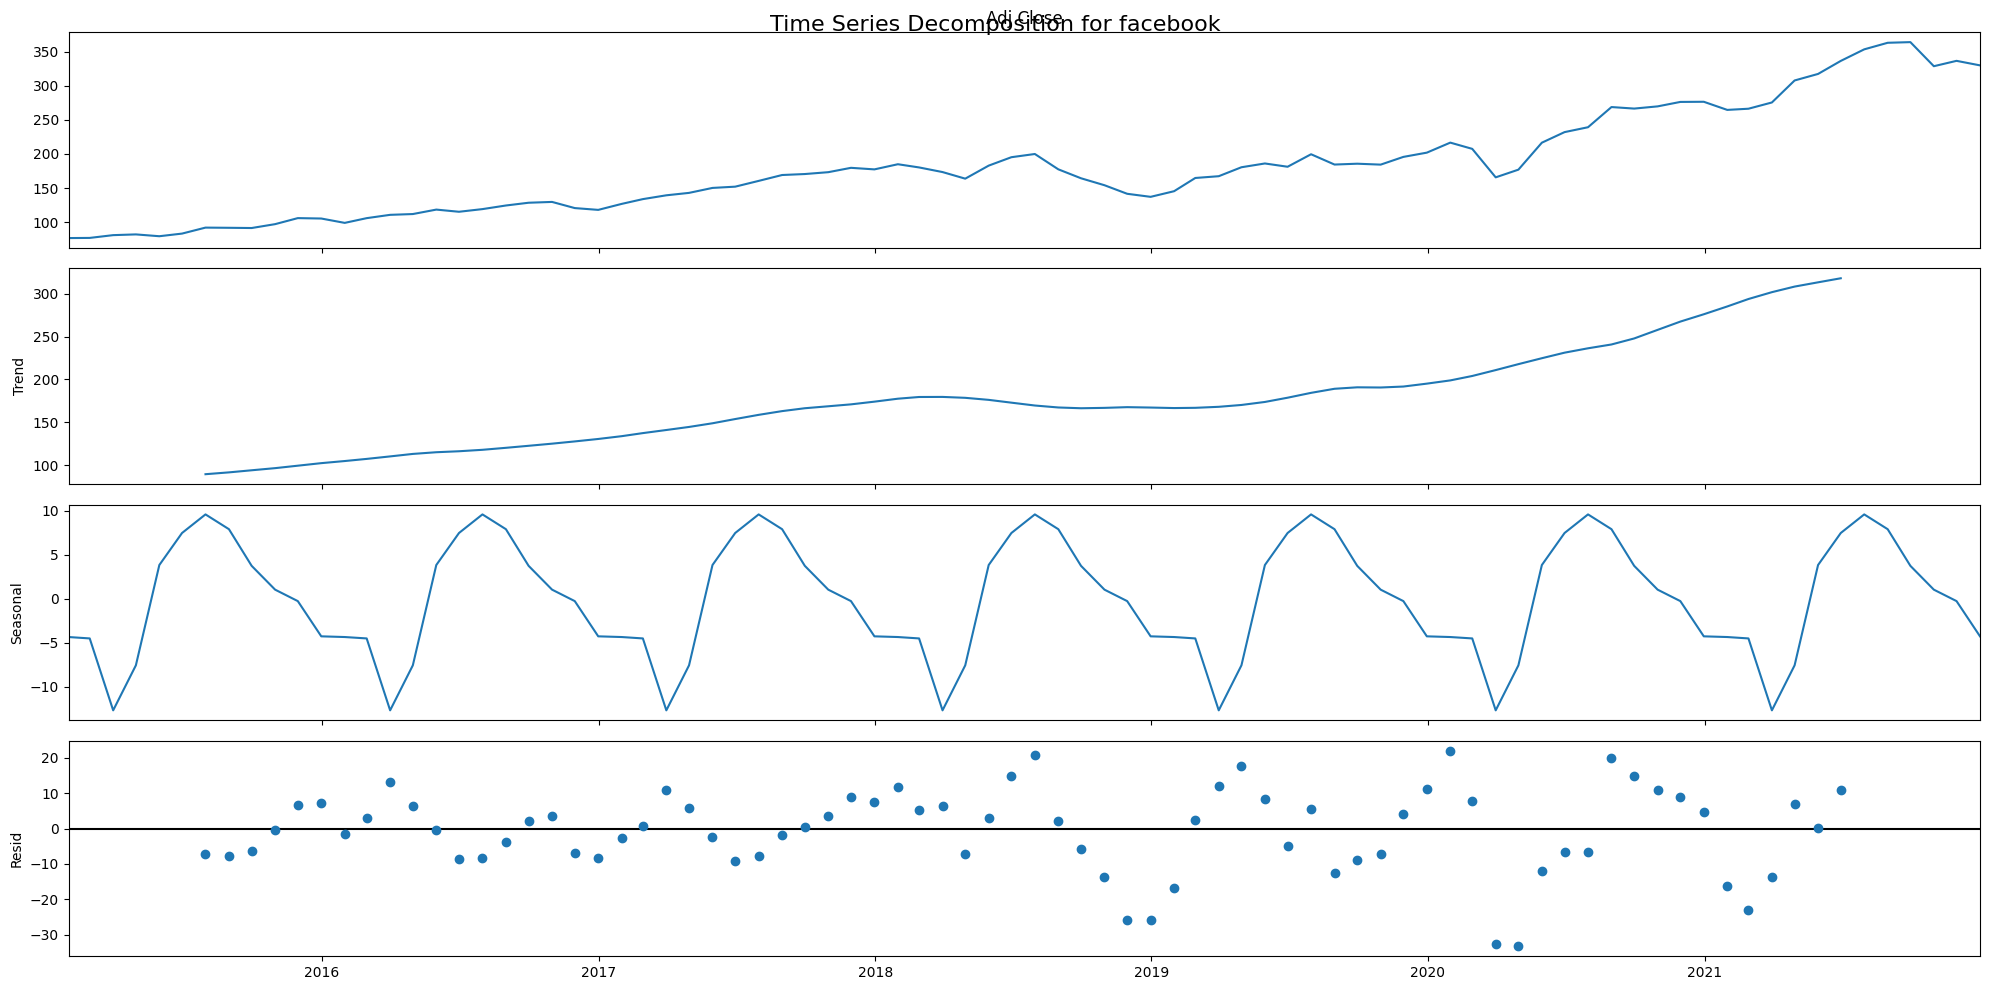

<Figure size 1400x1000 with 0 Axes>

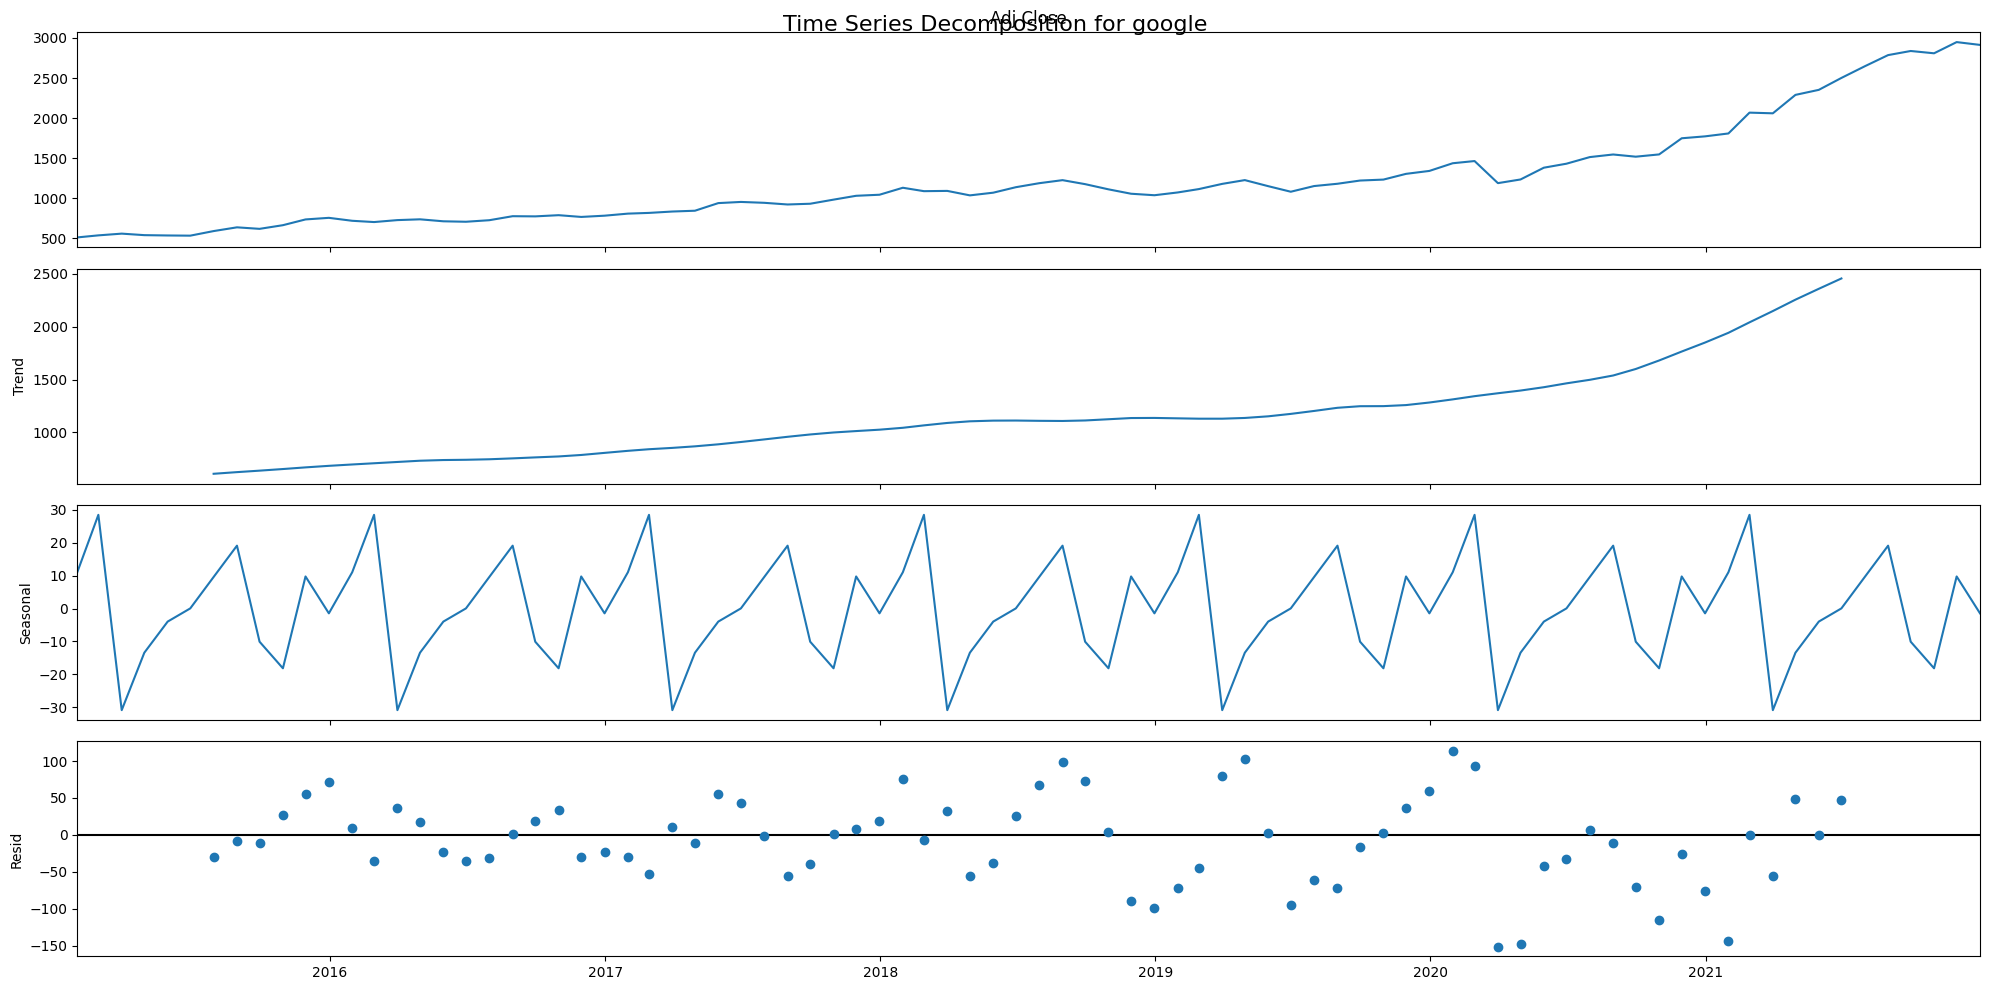

<Figure size 1400x1000 with 0 Axes>

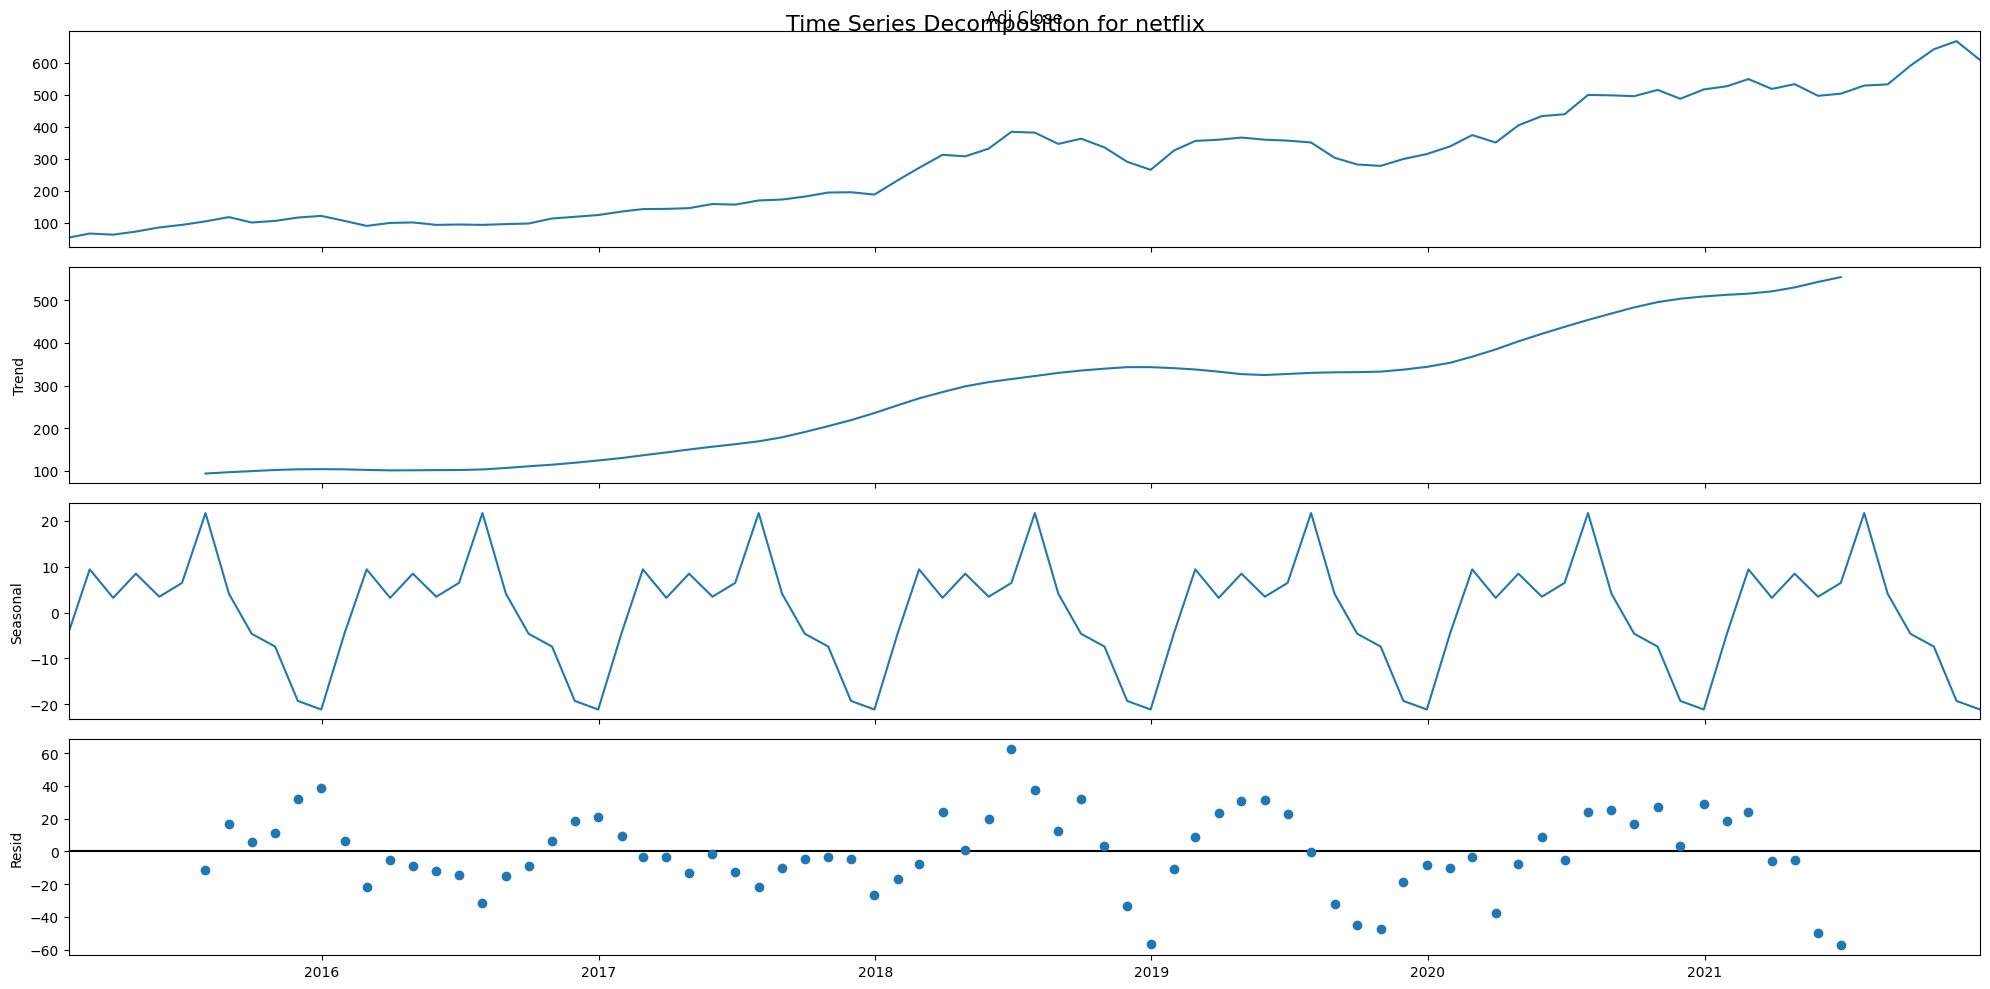

In [20]:
def seasonality(data):
    data.set_index('Date', inplace=True)
    
    # Decompose the time series for each company
    for company in data['company'].unique():
        company_data = data[data['company'] == company]
        company_data = company_data.select_dtypes(include='number').resample('M').mean()
        if len(company_data) > 12:  # Minimum length for seasonal decomposition
            decomposed = seasonal_decompose(company_data['Adj Close'].dropna(), model='additive')
            plt.figure(figsize=(14, 10))
            decomposed.plot()
            plt.suptitle(f'Time Series Decomposition for {company}', fontsize=16)
            plt.show()
        else:
            print(f"Not enough data for decomposition for {company}")

data_2 = data.copy()
seasonality(data_2)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8805 entries, 0 to 1760
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       8805 non-null   datetime64[ns]
 1   Open       8805 non-null   float64       
 2   High       8805 non-null   float64       
 3   Low        8805 non-null   float64       
 4   Close      8805 non-null   float64       
 5   Adj Close  8805 non-null   float64       
 6   Volume     8805 non-null   int64         
 7   company    8805 non-null   object        
 8   Month      8805 non-null   int32         
 9   Year       8805 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(2), int64(1), object(1)
memory usage: 687.9+ KB


Processing LSTM prediction for: amazon
-----------------------------------------------------------------------------
----------- STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM) -----------
-----------------------------------------------------------------------------
Shape of Training Set: (1321, 1)
Shape of Validation Set: (440, 1)
1281/1281 - 19s - 15ms/step - loss: 8.1135e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
RMSE value on validation set for amazon: 427.6332641129213


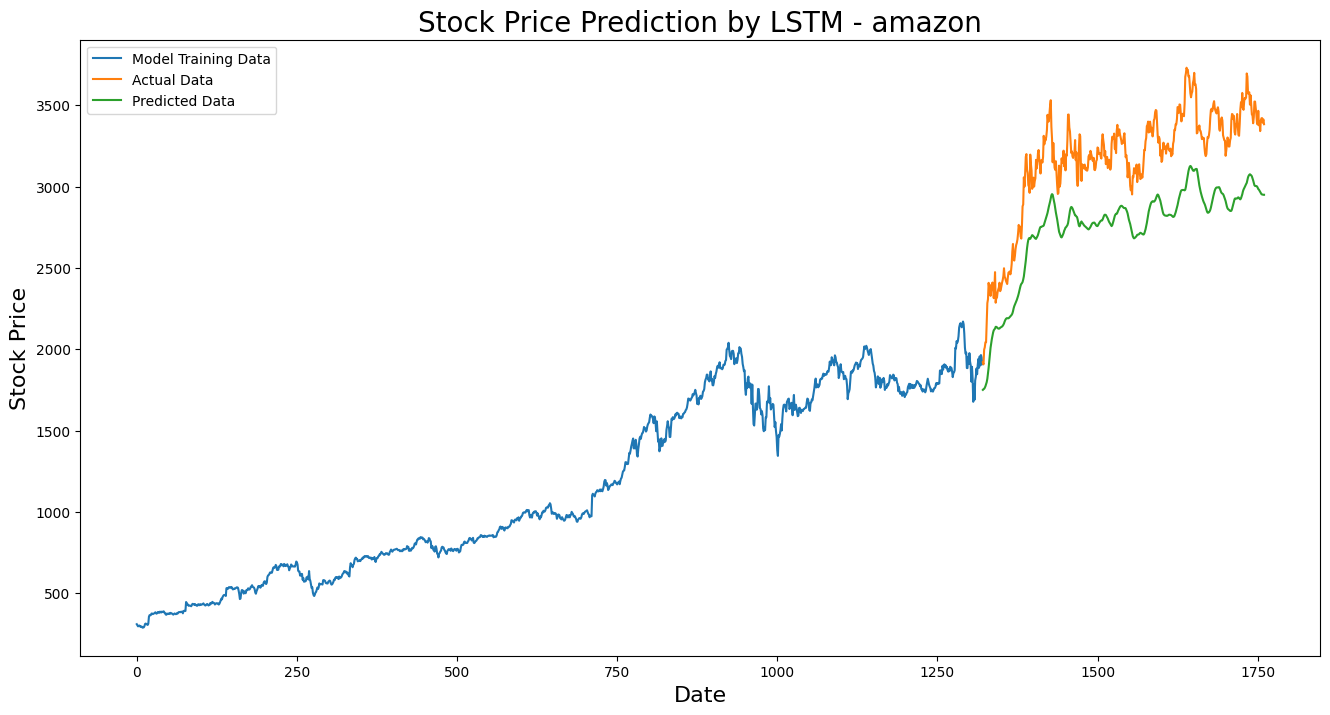

Processing LSTM prediction for: apple
-----------------------------------------------------------------------------
----------- STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM) -----------
-----------------------------------------------------------------------------
Shape of Training Set: (1321, 1)
Shape of Validation Set: (440, 1)
1281/1281 - 19s - 15ms/step - loss: 3.7035e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RMSE value on validation set for apple: 5.018870464596908


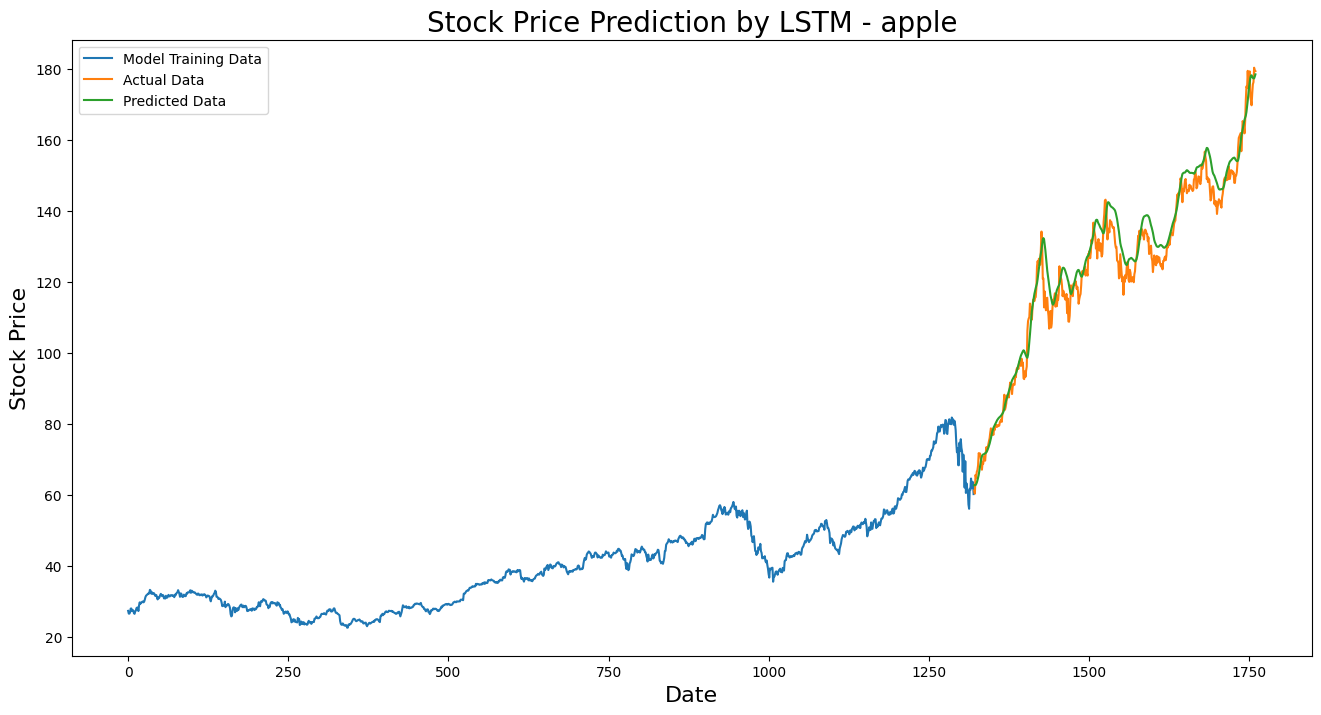

Processing LSTM prediction for: facebook
-----------------------------------------------------------------------------
----------- STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM) -----------
-----------------------------------------------------------------------------
Shape of Training Set: (1321, 1)
Shape of Validation Set: (440, 1)
1281/1281 - 19s - 15ms/step - loss: 6.6162e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RMSE value on validation set for facebook: 24.389728431931033


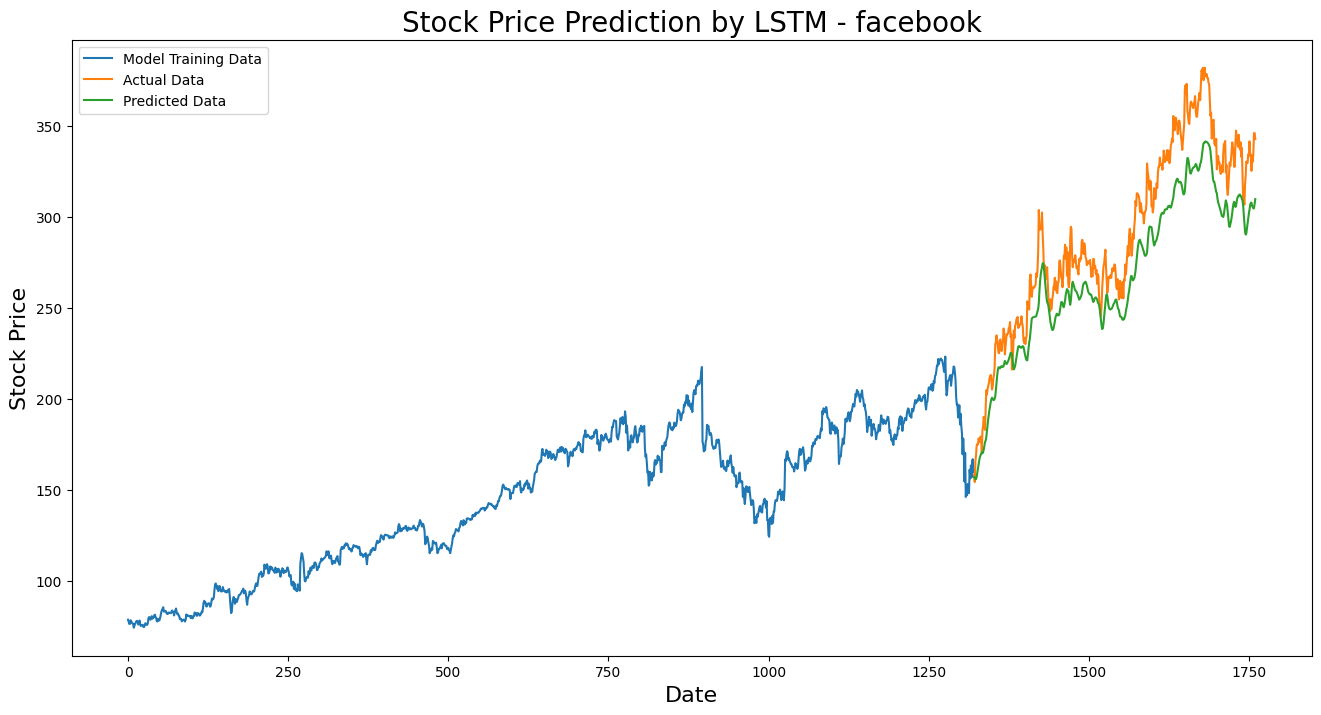

Processing LSTM prediction for: google
-----------------------------------------------------------------------------
----------- STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM) -----------
-----------------------------------------------------------------------------
Shape of Training Set: (1321, 1)
Shape of Validation Set: (440, 1)
1281/1281 - 19s - 15ms/step - loss: 4.8659e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
RMSE value on validation set for google: 101.4262641381224


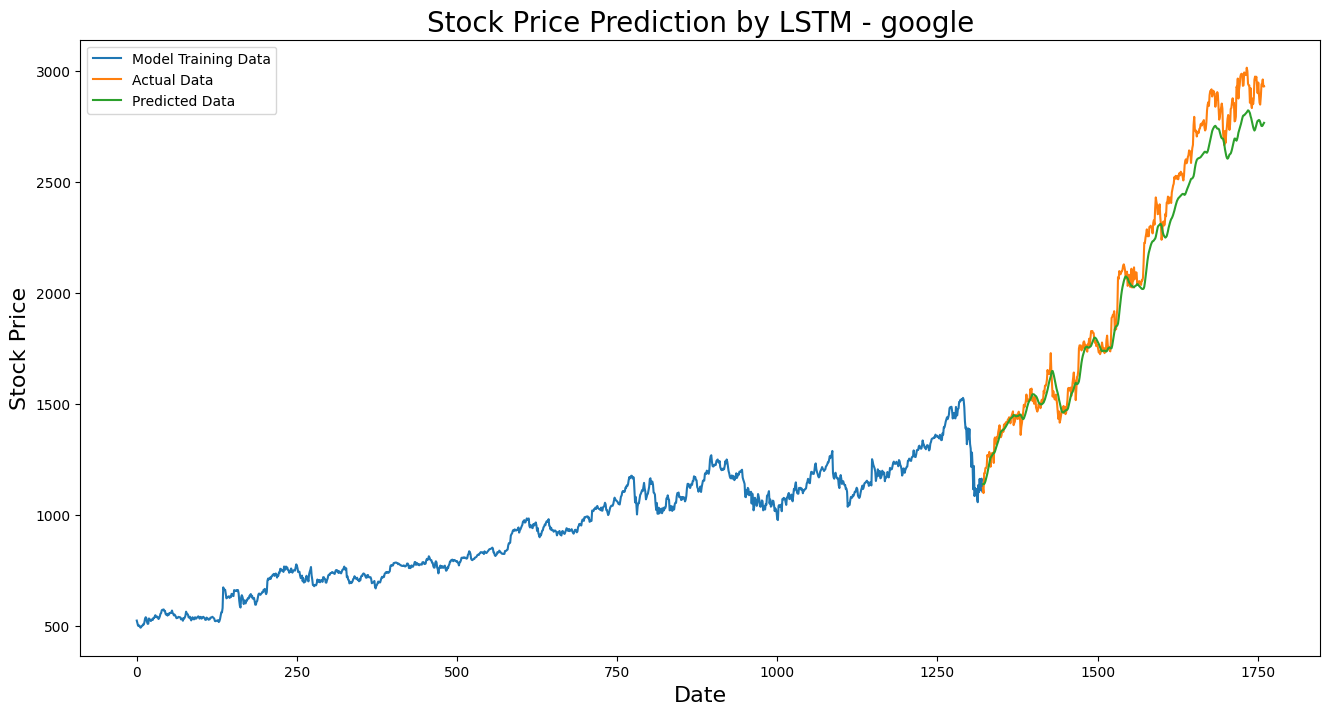

Processing LSTM prediction for: netflix
-----------------------------------------------------------------------------
----------- STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM) -----------
-----------------------------------------------------------------------------
Shape of Training Set: (1321, 1)
Shape of Validation Set: (440, 1)
1281/1281 - 19s - 15ms/step - loss: 0.0011
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
RMSE value on validation set for netflix: 19.28423494718117


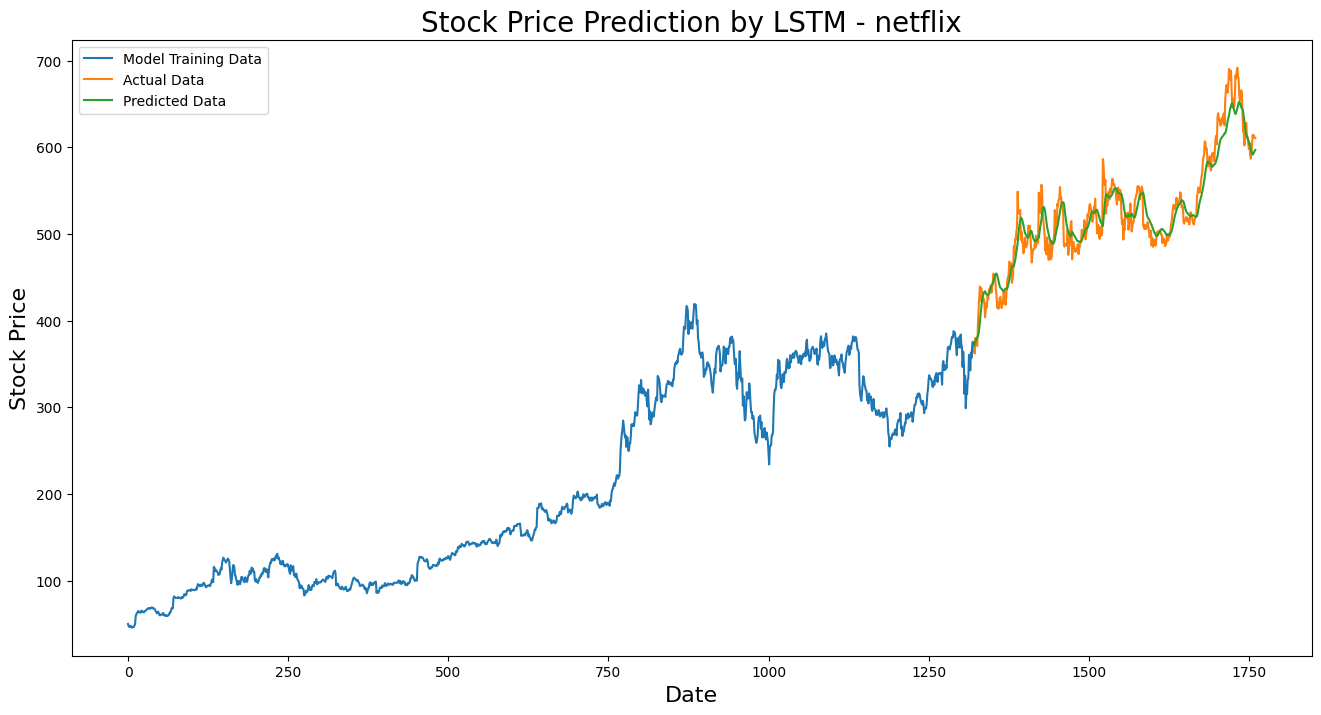

In [22]:
def lstm_prediction(data, company_name):
    print(f"Processing LSTM prediction for: {company_name}")
    
    shape = data.shape[0]
    data_new = data[['Close']]
    dataset = data_new.values
    
    # Split the data into training and validation sets
    train = data_new[:ceil(shape * 0.75)]
    valid = data_new[ceil(shape * 0.75):]
    
    print('-----------------------------------------------------------------------------')
    print('----------- STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM) -----------')
    print('-----------------------------------------------------------------------------')
    print(f'Shape of Training Set: {train.shape}')
    print(f'Shape of Validation Set: {valid.shape}')
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    
    # Prepare training data
    x_train, y_train = [], []
    for i in range(40, len(train)):
        x_train.append(scaled_data[i - 40:i, 0])
        y_train.append(scaled_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Train the model
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    
    # Prepare validation data
    inputs = data_new[len(data_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)
    
    X_test = []
    for i in range(40, inputs.shape[0]):
        X_test.append(inputs[i - 40:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Predict stock prices
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    
    # Calculate RMSE
    rms = np.sqrt(np.mean(np.power((valid.values - closing_price), 2)))
    print(f'RMSE value on validation set for {company_name}: {rms}')
    
    # Plot the results
    valid['Predictions'] = closing_price
    plt.figure(figsize=(16, 8))
    plt.plot(train['Close'], label='Model Training Data')
    plt.plot(valid[['Close']], label='Actual Data')
    plt.plot(valid[['Predictions']], label='Predicted Data')
    plt.xlabel('Date', size=16)
    plt.ylabel('Stock Price', size=16)
    plt.title(f'Stock Price Prediction by LSTM - {company_name}', size=20)
    plt.legend()
    plt.show()

# Apply the function to each company
for company in data['company'].unique():
    company_data = data[data['company'] == company].copy()
    lstm_prediction(company_data, company)
